### This exercise was performed on ARCC Beartooth with the following environment/software packages:

#### Load Preinstalled Modules:
module load gcc12.2.0 miniconda3 git/2.37.0

#### Create environment then activate with:
conda env create -f whatev_ml_env.yml
conda activate whatev_ml_env

#### Make sure jupyter can see the kernel in your conda env so you can select from southpass interface dropdown:
python -m ipykernel install --user --name=whatev_conda

#### Download data to folder and extract
wget https://archive.ics.uci.edu/static/public/186/wine+quality.zip
unzip wine+quality.zip

### In prior exercises, we performed exploratory data analysis and cleaned our data initially - now we will perform machine learning on the data which we've already cleaned.

In [31]:
#importing all necessary libraries
import os,sys,platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as torch
import seaborn as sb
import sklearn as sk
import skopt as sko
from copy import deepcopy as copy

#Parallelizing and memory evaluation obtained through this library.  
#https://joblib.readthedocs.io/en/stable/
from joblib import Memory, Parallel, delayed

#Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#For ML preprocessing pipeline definition
from sklearn.pipeline import Pipeline

#Different sklearn model types
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC

#For searching through possible hyperparameters
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, cross_val_score, RepeatedStratifiedKFold

from sklearn.model_selection import train_test_split

#To create classifications
from sklearn.datasets import make_classification

from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay as showMatrix
from sklearn.metrics import roc_auc_score

#Utilizes Bayesian Search Optimizer from ScikitLearn Optimizer Library
#https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV
from skopt import BayesSearchCV, gp_minimize

#Get rid of all the annoying BayesSearchCV warnings associated with the RandomForestClassifier
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')


from IPython.display import Image


In [32]:
#confirm and checking platform and sotware versions in software stack
print(f"Python Platform:{platform.platform()}")
print(f"Python {sys.version}")
print(f"PyTorch Version: ", torch.__version__)
print(f"Pandas Version: " , pd.__version__)
print(f"SkLearn Version: " , sk.__version__)
print(f"SkLearn Optimizer Version: ", sko.__version__)

Python Platform:macOS-14.0-arm64-arm-64bit
Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]
PyTorch Version:  2.1.1
Pandas Version:  2.1.4
SkLearn Version:  1.3.0
SkLearn Optimizer Version:  0.9.0


In [33]:
#checking devices available,though I know this is unfortunately not usable here, I always include it in my code 
#So I can know what the run can "see"

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
# print the names
for i in available_gpus:
    print(torch.cuda.get_device_properties(i).name)

# Prints 'Tesla V100-SXM2-16GB', for example
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() or torch.backends.mps.is_available() else 'cpu')
print("Using device: ", device)

None
Using device:  cuda


In [34]:
#Class to display pdfs as embedded pdf within iframe - we'll need it to display the final paper.
class PDF(object):
  def __init__(self, pdf, size=(800,1200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)


In [35]:
#Import some data and get std info about data
#Make sure we're pointing at the right directory in relation to where we are.
print(os.getcwd())

#Import data and separate out
whitewinedata = pd.read_csv("winequality-white.csv",sep=';')
redwinedata = pd.read_csv("winequality-red.csv", sep=';')

#view raw data, get info about it, clean if necessary
whitewinedata.info() #information about range
whitewinedata.describe() #Description of features
whitewinedata.duplicated() #Do we have any duplicate values in our data?

#Determine which values in data are categorical vs numeric (continuous vs discrete)
cat_col = [col for col in whitewinedata.columns if whitewinedata[col].dtype=='object']
num_col = [col for col in whitewinedata.columns if whitewinedata[col].dtype!='object']
print("White Wine Categorical columns: ", cat_col)
print("White Wine Numerical columns: ", num_col)

#Do the same as above, but for white data.  
redwinedata.info()
redwinedata.describe()
redwinedata.duplicated()

cat_col = [col for col in redwinedata.columns if redwinedata[col].dtype=='object']
num_col = [col for col in redwinedata.columns if redwinedata[col].dtype!='object']
print("Red Wine Categorical columns: ", cat_col)
print("Red Wine Numerical columns: ", num_col)

#Transform and scale our data and pull out labels
whitewinelabels = whitewinedata.pop('quality')
redwinelabels = redwinedata.pop('quality')

#Split both the red and white datasets before scaling to prevent data leakage
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(whitewinedata, whitewinelabels, random_state=0)
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(redwinedata, redwinelabels, random_state=0)


/Users/lisa/Documents/GitHub/hyperparameter-optimization-lrstafford
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
White Wine Categorical columns:  []
White Wine Numerical c

In [36]:
#Creating a bunch of empty datasets in which to import data after scaling
#StandardScaler
std_scaled_train_red=[]
std_scaled_test_red=[]
std_scaled_train_white=[]
std_scaled_test_white=[]

#MinMaxScaler
mm_scaled_train_red=[]
mm_scaled_test_red=[]
mm_scaled_train_white=[]
mm_scaled_test_white=[]

#RobustScaler
rob_scaled_train_red=[]
rob_scaled_test_red=[]
rob_scaled_train_white=[]
rob_scaled_test_white=[]

In [37]:
#Make dicts of all scalers to later easily pull full datasets specifically scaled in specific ways
scalers = {
    'types': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    
    'train_loc': [std_scaled_train_red,std_scaled_train_white,
                  mm_scaled_train_red,mm_scaled_test_white,
                  rob_scaled_train_red, rob_scaled_train_white],
    'test_loc':[std_scaled_test_red, std_scaled_test_white,
                mm_scaled_test_red, mm_scaled_test_white,
                rob_scaled_test_red, rob_scaled_test_white],
    
    'red_loc': [std_scaled_train_red, mm_scaled_train_red, rob_scaled_train_red,
               std_scaled_test_red, mm_scaled_test_red, rob_scaled_test_red],
    'white_loc': [std_scaled_train_white, mm_scaled_train_white, rob_scaled_train_white,
               std_scaled_test_white, mm_scaled_test_white, rob_scaled_test_white],
    
    'red_std_loc': [std_scaled_train_red, std_scaled_test_red, y_train_red, y_test_red],
    'white_std_loc': [std_scaled_train_white, std_scaled_test_white, y_train_white, y_test_white],
    
    'red_mm_loc': [mm_scaled_train_red, mm_scaled_test_red, y_train_red, y_test_red],
    'white_mm_loc': [mm_scaled_train_white, mm_scaled_test_white, y_train_white, y_test_white],   
    
    'red_rob_loc': [rob_scaled_train_red, rob_scaled_test_red, y_train_red, y_test_red],
    'white_rob_loc': [rob_scaled_train_white, rob_scaled_test_white, y_train_white, y_test_white],
}

In [8]:
#Def list of wine data subsets (red & white)
winetypes = {'types': ['red','white']}

#Create ranges of scaled datasets:
for wines in winetypes.get('types'):
    if wines == 'red':
        X_train, X_test, y_train, y_test = X_train_red, X_test_red, y_train_red, y_test_red
    else:
        X_train, X_test, y_train, y_test = X_train_white, X_test_white, y_train_white, y_test_white
        
    for scales in scalers.get('types'):
        scaledtraindata = scales.fit_transform(X_train)
        scaledtestdata = scales.fit_transform(X_test) 
        #print("got through the scale, fit, transform")
        
        if str(scales) == 'StandardScaler()':
            if wines == 'red':
                std_scaled_train_red = scaledtraindata
                std_scaled_test_red = scaledtestdata
                #print("got through making std_scaled_red data from scaledtestdata")
            else:
                std_scaled_train_white = scaledtraindata
                std_scaled_test_white = scaledtestdata
                #print("got through making std_scaled_white data from scaledtestdata")
                
        elif str(scales) == 'MinMaxScaler()':
            if wines == 'red':
                mm_scaled_train_red = scaledtraindata
                mm_scaled_test_red = scaledtestdata
                #print("got through making mm_scaled_red data from scaledtestdata")
                
            else:
                mm_scaled_train_white = scaledtraindata
                mm_scaled_test_white = scaledtestdata
                #print("got through making mm_scaled_white data from scaledtestdata")
                
        elif str(scales) == 'RobustScaler()':
            if wines == 'red':
                rob_scaled_train_red = scaledtraindata
                rob_scaled_test_red = scaledtestdata
                #print("got through making rob_scaled_red data from scaledtestdata")
                
            else:
                rob_scaled_train_white = scaledtraindata
                rob_scaled_test_white = scaledtestdata
                #print("got through making rob_scaled_white data from scaledtestdata")
   
#Make dicts of all scalers to later easily pull full datasets specifically scaled in specific ways
scalers = {
    'types': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    
    'train_loc': [std_scaled_train_red,std_scaled_train_white,
                  mm_scaled_train_red,mm_scaled_test_white,
                  rob_scaled_train_red, rob_scaled_train_white],
    'test_loc':[std_scaled_test_red, std_scaled_test_white,
                mm_scaled_test_red, mm_scaled_test_white,
                rob_scaled_test_red, rob_scaled_test_white],
    
    'red_loc': [std_scaled_train_red, mm_scaled_train_red, rob_scaled_train_red,
               std_scaled_test_red, mm_scaled_test_red, rob_scaled_test_red],
    'white_loc': [std_scaled_train_white, mm_scaled_train_white, rob_scaled_train_white,
               std_scaled_test_white, mm_scaled_test_white, rob_scaled_test_white],
    
    'red_std_loc': [std_scaled_train_red, std_scaled_test_red, y_train_red, y_test_red],
    'white_std_loc': [std_scaled_train_white, std_scaled_test_white, y_train_white, y_test_white],
    
    'red_mm_loc': [mm_scaled_train_red, mm_scaled_test_red, y_train_red, y_test_red],
    'white_mm_loc': [mm_scaled_train_white, mm_scaled_test_white, y_train_white, y_test_white],   
    
    'red_rob_loc': [rob_scaled_train_red, rob_scaled_test_red, y_train_red, y_test_red],
    'white_rob_loc': [rob_scaled_train_white, rob_scaled_test_white, y_train_white, y_test_white],
}

We'll be defining classes for each ML algorithm in the next couple sections:

Random Forest Classifier:  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

Kmeans Clustering: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Support Vector Machine
Linear: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

Classic/Poly: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

KNeighbor Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

SGD Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

Neural Network: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network

In [9]:
#Define dict random forest hyperparameters from which to optimize/search
rfcparams = {
    'n_estimators': [10, 25, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 25],
    'bootstrap': [True, False],
    'warm_start': [True, False],
    'n_jobs': [-1]
}


In [10]:
#Define dict kmeans clustering hyperparameters from which to optimize/search
kmparams = {
    'n_clusters': [3, 4, 5],
    'n_jobs': [-1],
    'max_iter': [100,300,500],
    'tol': [0.0001, 0.0005, 0.001],
    'boostrap': [True, False],
    'algorithm': ['lloyd', 'elkan'],
    'n_init': [5,10]
}


In [11]:
#Define knn hyperparameters dict from which to optimize
knnparams = {
    'n_neighbors': [5, 10, 25, 50], 
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree'],
    'n_jobs': [-1]
}

In [12]:
#Define dict set of hyperparams to search through in dict 
sgdparams = [
    { #Smooth loss tolerating outliers
        'loss': ['squared_hinge'], 'penalty': ['l1','l2','elasticnet'],
        'epsilon': [0.05, 0.1, 0.5, 1, 10],
        'fit_intercept': [True],
        'max_iter': [2000],
        'tol': [1e-3, 1e-4, 1e-5],
        'early_stopping': [True],
        'warm_start': [True, False],
        'n_jobs': [-1]
    },
    { #Smooth loss tolerating outliers
        'loss': ['modified_huber'], 'penalty': ['l1','l2','elasticnet'],
        'epsilon': [0.05, 0.1, 0.5, 1, 10],
        'fit_intercept': [True],
        'max_iter': [2000],
        'tol': [1e-3, 1e-4, 1e-5],
        'early_stopping': [True],
        'warm_start': [True, False],
        'n_jobs': [-1]
    },
    { #logistic regression SVM
        'loss': ['log_loss'], 'penalty': ['l1','l2', 'elasticnet'],
        'alpha': [0.001, 0.0001, 0.00005],
        'fit_intercept': [True],
        'max_iter': [2000],
        'tol': [1e-3, 1e-4, 1e-5],
        'early_stopping': [True],
        'warm_start': [True, False],
        'n_jobs': [-1]
    },

    { #Perceptron
        'loss': ['perceptron'], 'penalty': ['l1','l2','elasticnet'],
        'fit_intercept': [True],
        'max_iter': [2000],
        'tol': [1e-3, 1e-4, 1e-5],
        'early_stopping': [True],
        'warm_start': [True, False],
        'n_jobs': [-1]
    }  
]

In [13]:
#define dicts set of mlp hyperparams to search through
mlpparams = [
    { #Adams solver
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['adam'],
        'alpha': [0.001, 0.0001, 0.00001],
        'max_iter': [1000],
        'tol': [1e-3,1e-4,1e-5],
        'early_stopping': [True],
        'warm_start': [True, False]
    },
    
    { #SGD solver 
        'activation': ['identity', 'logistic', 'relu'],
        'solver': ['sgd'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'momentum': [0.9, 0.95, 0.99],
        'alpha': [0.001, 0.0001, 0.00001],
        'max_iter': [1000],
        'tol': [1e-3,1e-4,1e-5],
        'early_stopping': [True],
        'warm_start': [True, False]
    }
]

In [14]:
#Make an empty pandas dataframe in which to store model performance data:
performance_scores = pd.DataFrame(columns=['Classifier',
                                           'Wine_Type', 
                                           'Scaler',
                                           'Training_Score', 
                                           'Test_Score', 'HP Optimizer Technique'])

display(performance_scores)

,Classifier,Wine_Type,Scaler,Training_Score,Test_Score,HP Optimizer Technique


In [15]:
#Makes empty dataframes in which to store best parameters list.

best_params_rfc = pd.DataFrame(columns=[])
best_params_knn = pd.DataFrame(columns=[])
best_params_sgd = pd.DataFrame(columns=[])
best_params_mlpc = pd.DataFrame(columns=[])

In [16]:
#Define list of models to evaluate
models = {
    'types': ['rfc', 'knn', 'sgd', 'mlpc'],
    'rfc': [RandomForestClassifier(), rfcparams],
    #'kmeans': [KMeans(), kmparams],
    'knn': [KNeighborsClassifier(), knnparams],
    'sgd': [SGDClassifier(), sgdparams],
    'mlpc': [MLPClassifier(), mlpparams]
}

In [17]:
#Stupid little function to make sure data looks right for following function
def conform_data(xtrain,xtest,ytrain,ytest):
    data = xtrain,xtest,ytrain,ytest
    return data


In [18]:
def get_range(df):
    max = df.max(0)
    min = df.min(0)
    return min, max

In [19]:
get_range(y_test)

(3, 8)

In [21]:
#General model to train data in different models using different hyperparams
def eval_model(data, winetype, modtype, hopt):
    best_params = pd.DataFrame()
    #Extract data for training and eval
    X_train, X_test, y_train, y_test = data
    
    #Parse training based on model, hyperparams, and wine type.
    if modtype in models:
        #Pull the model type from dict
        hpopt = models.get(modtype)[1]
        #Pull classifiers from modtype
        classifier = models.get(modtype)[0]
        #Using GridSearch for HP Optimization
        if hopt == 'grid': 
            classifier = GridSearchCV(classifier, hpopt)
            
        #Using randomized HP Optimization   
        elif hopt == 'rand': 
            #if NN, run randomized search for NN
            if modtype == MLPClassifier():
                classifier = RandomizedSearchCV(classifier, param_distributions = hpopt, n_iters=2)
                best_params = best_params_mlpc
            elif modtype == SGDClassifier():
                classifier = RandomizedSearchCV(classifier, param_distributions = hpopt, n_iters=3)
                best_params = best_params_sgd
            else:
                classifier = RandomizedSearchCV(classifier, hpopt) 
                if modtype == RandomForestClassifier():
                    best_params = best_params_rfc
                else:
                    best_params = best_params_knn
                    
        #Using Half Grid Search    
        elif hopt == 'halfgrid': 
            classifier = HalvingGridSearchCV(classifier, hpopt)
            
        #Using Evolutionary Algo for HP Optimization    
        elif hopt == 'evol': 
            classifier = models.get(modtype)[0]
            
        #Using Bayesian Opt for HP Optimization    
        else:    
            #To fix a problem that occurs with compatibility between np versions and BayesSearch lib.
            np.int = int 
            # define the search
            classifier = BayesSearchCV(estimator=models.get(modtype)[0], search_spaces=hpopt, n_jobs=-1, cv=3)
            
    classifier.fit(X_train, y_train)
    
    train_pred = classifier.predict(X_train)
    test_pred = classifier.predict(X_test)
     
    trainacc = accuracy_score(train_pred, y_train)
    testacc = accuracy_score(test_pred, y_test)

    
    print("Accuracy of", classifier, "on", winetype, "training is:", trainacc)
    print("Accuracy of", classifier, "on", winetype, "test data is:", testacc)


    winematrix = cm(y_test, test_pred)
    print(type(y_test))

    print("best params: %s" % str(classifier.best_params_))
    
        
    #best_params = pd.concat([best_params, pd.DataFrame.from_dict()], ignore_index=True)    
    #to handle errors associated with printing matrices for different models
    if modtype == 'kmeans':
        disp = showMatrix(winematrix, display_labels=[1,2,3,4,5,6,7,8,9])
    else:
        try: disp = showMatrix(winematrix, display_labels=[3,4,5,6,7,8]) 
        except LabelError:
            print("Cannot use 3-8 as labels.  Trying labels 3-9")
            disp = showMatrix(winematrix, display_labels=[3,4,5,6,7,8,9])           
        except NewLabels:
            print("Labels 3-9 didn't work.  Default.") 
            disp = showMatrix(winematrix)      
        
        try: 
            #get_range(wi)
            roc = roc_auc_score(test_pred, multi_class='ovo')
            print("Roc_Auc_Score is: ", roc) 
        except Exception as e: 
            print("this sucks. No idea", e)
              
    disp.plot()
    plt.show()
   
    return trainacc, testacc, hopt


In [22]:
#Implement evaluation function using successive halving
def halving_eval():
    return 1
    

In [29]:
def runeval(scales):
    for wines in winetypes.get('types'):
        for scales in scalers.get('types'):
            for modtypes in models.get('types'):
                if str(scales) == 'Standard_Scaler()':
                    if wines == 'red':
                        dat = scalers.get('red_std_loc')

                    else:
                        dat = scalers.get('white_std_loc')
                elif str(scales) == 'MinMaxScaler()':
                    if wines == 'red':
                        dat = scalers.get('red_mm_loc')
                    else:
                        dat = scalers.get('white_mm_loc')
                else: #scale is RobustScaler()
                    if wines == 'red':
                        dat = scalers.get('red_rob_loc')
                    else:
                        dat = scalers.get('white_rob_loc')
                print(wines, scales, modtypes, '\n')  

                trainac, testac, hpoptim = eval_model(dat, wines, modtypes,'bayes')
                performance_scores.loc[len(performance_scores)] = [modtypes, wines, scales, trainac, testac, hpoptim]


red StandardScaler() rfc 

Accuracy of BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [None, 10, 25],
                             'n_estimators': [10, 25, 100], 'n_jobs': [-1],
                             'warm_start': [True, False]}) on red training is: 1.0
Accuracy of BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [None, 10, 25],
                             'n_estimators': [10, 25, 100], 'n_jobs': [-1],
                             'warm_start': [True, False]}) on red test data is: 0.6575
<class 'pandas.core.series.Series'>
best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('ma

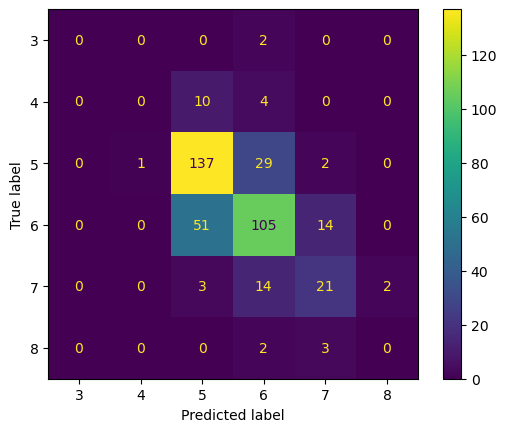

red StandardScaler() knn 

Accuracy of BayesSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
              search_spaces={'algorithm': ['ball_tree', 'kd_tree'],
                             'n_jobs': [-1], 'n_neighbors': [5, 10, 25, 50],
                             'weights': ['uniform', 'distance']}) on red training is: 1.0
Accuracy of BayesSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
              search_spaces={'algorithm': ['ball_tree', 'kd_tree'],
                             'n_jobs': [-1], 'n_neighbors': [5, 10, 25, 50],
                             'weights': ['uniform', 'distance']}) on red test data is: 0.6325
<class 'pandas.core.series.Series'>
best params: OrderedDict([('algorithm', 'ball_tree'), ('n_jobs', -1), ('n_neighbors', 50), ('weights', 'distance')])
this sucks. No idea name 'wi' is not defined


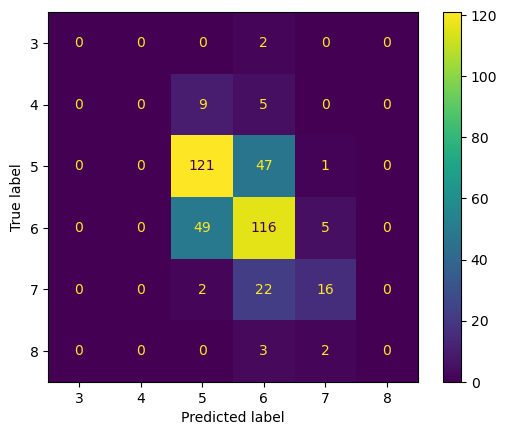

red StandardScaler() sgd 

Accuracy of BayesSearchCV(cv=3, estimator=SGDClassifier(), n_jobs=-1,
              search_spaces=[{'early_stopping': [True],
                              'epsilon': [0.05, 0.1, 0.5, 1, 10],
                              'fit_intercept': [True],
                              'loss': ['squared_hinge'], 'max_iter': [2000],
                              'n_jobs': [-1],
                              'penalty': ['l1', 'l2', 'elasticnet'],
                              'tol': [0.001, 0.0001, 1e-05],
                              'warm_start': [True, False]},
                             {'early_stopping': [True],
                              'epsilon': [0.05, 0.1, 0.5, 1, 10],
                              '...
                              'early_stopping': [True], 'fit_intercept': [True],
                              'loss': ['log_loss'], 'max_iter': [2000],
                              'n_jobs': [-1],
                              'penalty': ['l1', 'l2', 'el

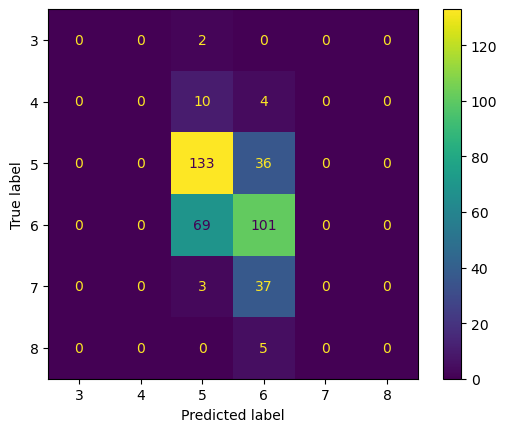

red StandardScaler() mlpc 

Accuracy of BayesSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
              search_spaces=[{'activation': ['identity', 'logistic', 'tanh',
                                             'relu'],
                              'alpha': [0.001, 0.0001, 1e-05],
                              'early_stopping': [True], 'max_iter': [1000],
                              'solver': ['adam'], 'tol': [0.001, 0.0001, 1e-05],
                              'warm_start': [True, False]},
                             {'activation': ['identity', 'logistic', 'relu'],
                              'alpha': [0.001, 0.0001, 1e-05],
                              'early_stopping': [True],
                              'learning_rate': ['constant', 'invscaling',
                                                'adaptive'],
                              'max_iter': [1000], 'momentum': [0.9, 0.95, 0.99],
                              'solver': ['sgd'], 'tol': [0.001, 0.0001, 1e-05]

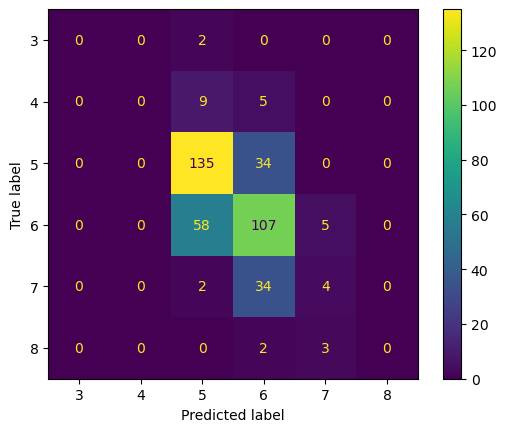

red MinMaxScaler() rfc 

Accuracy of BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [None, 10, 25],
                             'n_estimators': [10, 25, 100], 'n_jobs': [-1],
                             'warm_start': [True, False]}) on red training is: 1.0
Accuracy of BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [None, 10, 25],
                             'n_estimators': [10, 25, 100], 'n_jobs': [-1],
                             'warm_start': [True, False]}) on red test data is: 0.5925
<class 'pandas.core.series.Series'>
best params: OrderedDict([('bootstrap', True), ('criterion', 'log_loss'), ('max

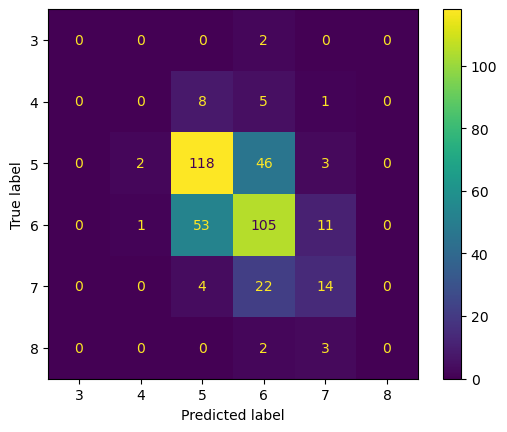

red MinMaxScaler() knn 

Accuracy of BayesSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
              search_spaces={'algorithm': ['ball_tree', 'kd_tree'],
                             'n_jobs': [-1], 'n_neighbors': [5, 10, 25, 50],
                             'weights': ['uniform', 'distance']}) on red training is: 1.0
Accuracy of BayesSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
              search_spaces={'algorithm': ['ball_tree', 'kd_tree'],
                             'n_jobs': [-1], 'n_neighbors': [5, 10, 25, 50],
                             'weights': ['uniform', 'distance']}) on red test data is: 0.6
<class 'pandas.core.series.Series'>
best params: OrderedDict([('algorithm', 'kd_tree'), ('n_jobs', -1), ('n_neighbors', 50), ('weights', 'distance')])
this sucks. No idea name 'wi' is not defined


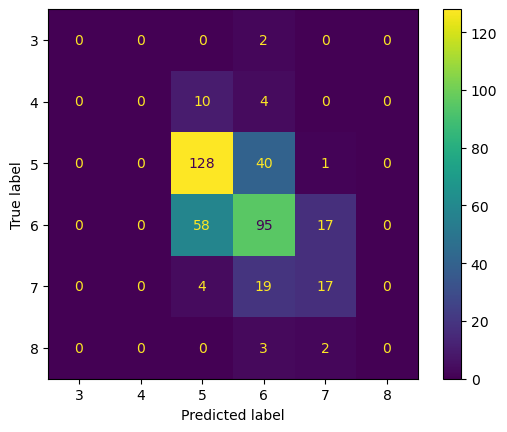

red MinMaxScaler() sgd 

Accuracy of BayesSearchCV(cv=3, estimator=SGDClassifier(), n_jobs=-1,
              search_spaces=[{'early_stopping': [True],
                              'epsilon': [0.05, 0.1, 0.5, 1, 10],
                              'fit_intercept': [True],
                              'loss': ['squared_hinge'], 'max_iter': [2000],
                              'n_jobs': [-1],
                              'penalty': ['l1', 'l2', 'elasticnet'],
                              'tol': [0.001, 0.0001, 1e-05],
                              'warm_start': [True, False]},
                             {'early_stopping': [True],
                              'epsilon': [0.05, 0.1, 0.5, 1, 10],
                              '...
                              'early_stopping': [True], 'fit_intercept': [True],
                              'loss': ['log_loss'], 'max_iter': [2000],
                              'n_jobs': [-1],
                              'penalty': ['l1', 'l2', 'elas

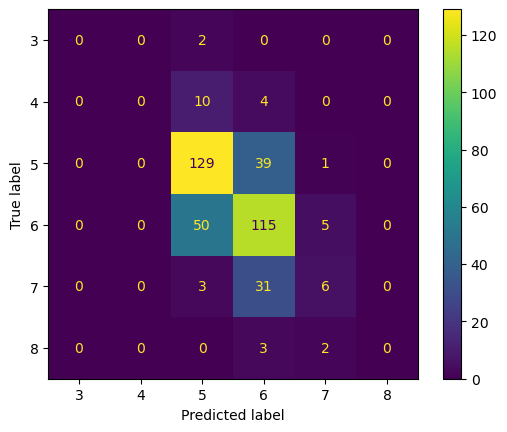

red MinMaxScaler() mlpc 

Accuracy of BayesSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
              search_spaces=[{'activation': ['identity', 'logistic', 'tanh',
                                             'relu'],
                              'alpha': [0.001, 0.0001, 1e-05],
                              'early_stopping': [True], 'max_iter': [1000],
                              'solver': ['adam'], 'tol': [0.001, 0.0001, 1e-05],
                              'warm_start': [True, False]},
                             {'activation': ['identity', 'logistic', 'relu'],
                              'alpha': [0.001, 0.0001, 1e-05],
                              'early_stopping': [True],
                              'learning_rate': ['constant', 'invscaling',
                                                'adaptive'],
                              'max_iter': [1000], 'momentum': [0.9, 0.95, 0.99],
                              'solver': ['sgd'], 'tol': [0.001, 0.0001, 1e-05],


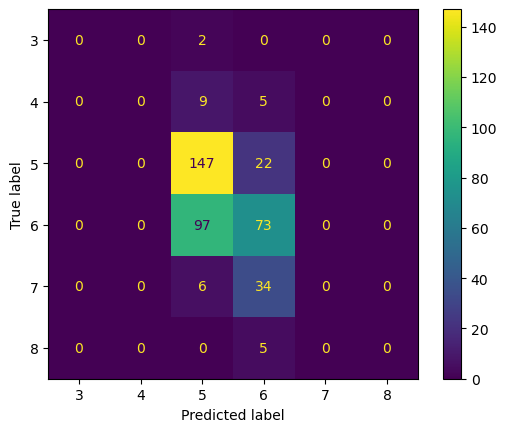

red RobustScaler() rfc 

Accuracy of BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [None, 10, 25],
                             'n_estimators': [10, 25, 100], 'n_jobs': [-1],
                             'warm_start': [True, False]}) on red training is: 1.0
Accuracy of BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [None, 10, 25],
                             'n_estimators': [10, 25, 100], 'n_jobs': [-1],
                             'warm_start': [True, False]}) on red test data is: 0.675
<class 'pandas.core.series.Series'>
best params: OrderedDict([('bootstrap', True), ('criterion', 'gini'), ('max_dept

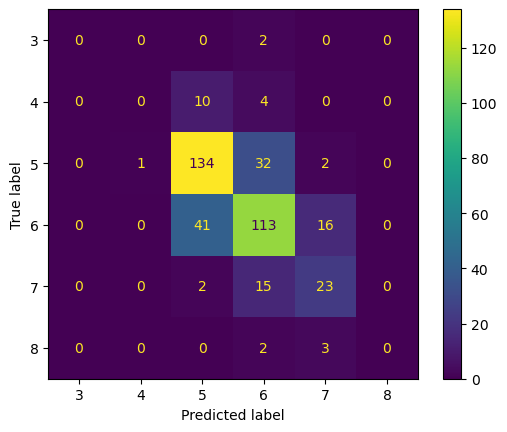

red RobustScaler() knn 

Accuracy of BayesSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
              search_spaces={'algorithm': ['ball_tree', 'kd_tree'],
                             'n_jobs': [-1], 'n_neighbors': [5, 10, 25, 50],
                             'weights': ['uniform', 'distance']}) on red training is: 1.0
Accuracy of BayesSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
              search_spaces={'algorithm': ['ball_tree', 'kd_tree'],
                             'n_jobs': [-1], 'n_neighbors': [5, 10, 25, 50],
                             'weights': ['uniform', 'distance']}) on red test data is: 0.6325
<class 'pandas.core.series.Series'>
best params: OrderedDict([('algorithm', 'ball_tree'), ('n_jobs', -1), ('n_neighbors', 50), ('weights', 'distance')])
this sucks. No idea name 'wi' is not defined


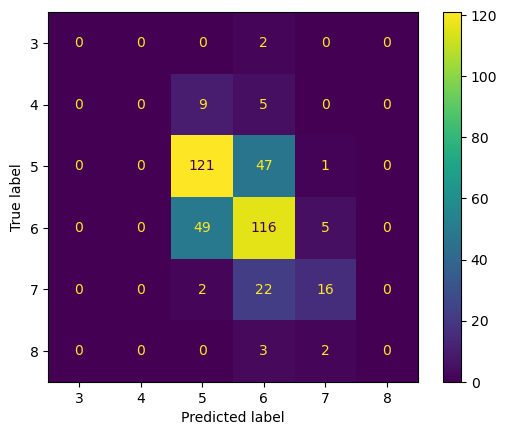

red RobustScaler() sgd 

Accuracy of BayesSearchCV(cv=3, estimator=SGDClassifier(), n_jobs=-1,
              search_spaces=[{'early_stopping': [True],
                              'epsilon': [0.05, 0.1, 0.5, 1, 10],
                              'fit_intercept': [True],
                              'loss': ['squared_hinge'], 'max_iter': [2000],
                              'n_jobs': [-1],
                              'penalty': ['l1', 'l2', 'elasticnet'],
                              'tol': [0.001, 0.0001, 1e-05],
                              'warm_start': [True, False]},
                             {'early_stopping': [True],
                              'epsilon': [0.05, 0.1, 0.5, 1, 10],
                              '...
                              'early_stopping': [True], 'fit_intercept': [True],
                              'loss': ['log_loss'], 'max_iter': [2000],
                              'n_jobs': [-1],
                              'penalty': ['l1', 'l2', 'elas

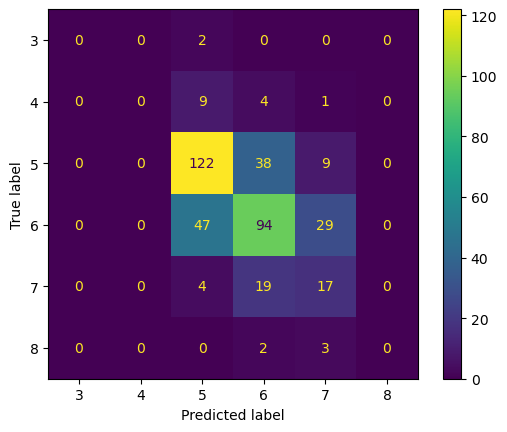

red RobustScaler() mlpc 

Accuracy of BayesSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
              search_spaces=[{'activation': ['identity', 'logistic', 'tanh',
                                             'relu'],
                              'alpha': [0.001, 0.0001, 1e-05],
                              'early_stopping': [True], 'max_iter': [1000],
                              'solver': ['adam'], 'tol': [0.001, 0.0001, 1e-05],
                              'warm_start': [True, False]},
                             {'activation': ['identity', 'logistic', 'relu'],
                              'alpha': [0.001, 0.0001, 1e-05],
                              'early_stopping': [True],
                              'learning_rate': ['constant', 'invscaling',
                                                'adaptive'],
                              'max_iter': [1000], 'momentum': [0.9, 0.95, 0.99],
                              'solver': ['sgd'], 'tol': [0.001, 0.0001, 1e-05],


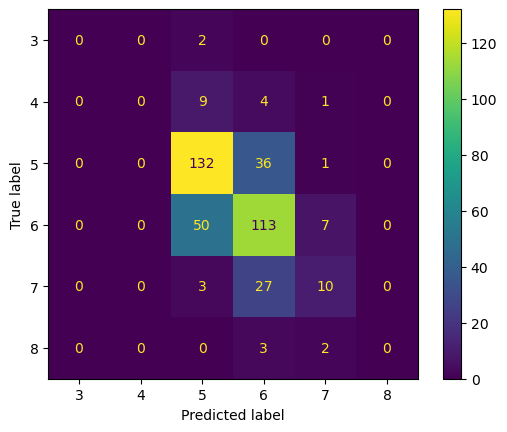

white StandardScaler() rfc 

Accuracy of BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [None, 10, 25],
                             'n_estimators': [10, 25, 100], 'n_jobs': [-1],
                             'warm_start': [True, False]}) on white training is: 1.0
Accuracy of BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [None, 10, 25],
                             'n_estimators': [10, 25, 100], 'n_jobs': [-1],
                             'warm_start': [True, False]}) on white test data is: 0.6555102040816326
<class 'pandas.core.series.Series'>
best params: OrderedDict([('bootstrap', True), ('criterion'

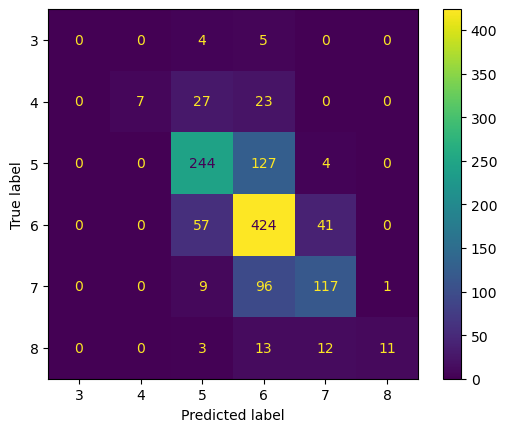

white StandardScaler() knn 

Accuracy of BayesSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
              search_spaces={'algorithm': ['ball_tree', 'kd_tree'],
                             'n_jobs': [-1], 'n_neighbors': [5, 10, 25, 50],
                             'weights': ['uniform', 'distance']}) on white training is: 1.0
Accuracy of BayesSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
              search_spaces={'algorithm': ['ball_tree', 'kd_tree'],
                             'n_jobs': [-1], 'n_neighbors': [5, 10, 25, 50],
                             'weights': ['uniform', 'distance']}) on white test data is: 0.5942857142857143
<class 'pandas.core.series.Series'>
best params: OrderedDict([('algorithm', 'kd_tree'), ('n_jobs', -1), ('n_neighbors', 25), ('weights', 'distance')])
this sucks. No idea name 'wi' is not defined


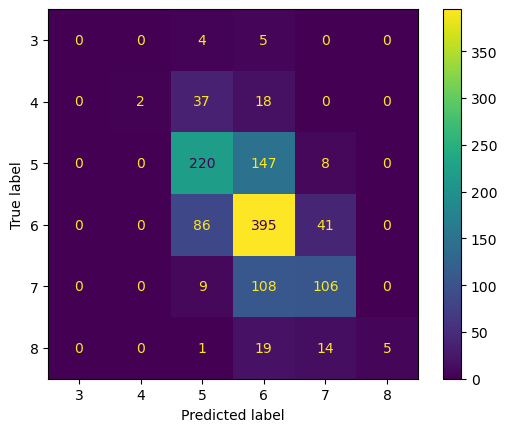

white StandardScaler() sgd 

Accuracy of BayesSearchCV(cv=3, estimator=SGDClassifier(), n_jobs=-1,
              search_spaces=[{'early_stopping': [True],
                              'epsilon': [0.05, 0.1, 0.5, 1, 10],
                              'fit_intercept': [True],
                              'loss': ['squared_hinge'], 'max_iter': [2000],
                              'n_jobs': [-1],
                              'penalty': ['l1', 'l2', 'elasticnet'],
                              'tol': [0.001, 0.0001, 1e-05],
                              'warm_start': [True, False]},
                             {'early_stopping': [True],
                              'epsilon': [0.05, 0.1, 0.5, 1, 10],
                              '...
                              'early_stopping': [True], 'fit_intercept': [True],
                              'loss': ['log_loss'], 'max_iter': [2000],
                              'n_jobs': [-1],
                              'penalty': ['l1', 'l2', '

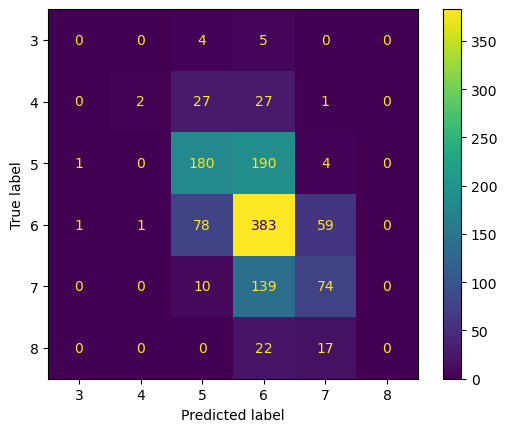

white StandardScaler() mlpc 

Accuracy of BayesSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
              search_spaces=[{'activation': ['identity', 'logistic', 'tanh',
                                             'relu'],
                              'alpha': [0.001, 0.0001, 1e-05],
                              'early_stopping': [True], 'max_iter': [1000],
                              'solver': ['adam'], 'tol': [0.001, 0.0001, 1e-05],
                              'warm_start': [True, False]},
                             {'activation': ['identity', 'logistic', 'relu'],
                              'alpha': [0.001, 0.0001, 1e-05],
                              'early_stopping': [True],
                              'learning_rate': ['constant', 'invscaling',
                                                'adaptive'],
                              'max_iter': [1000], 'momentum': [0.9, 0.95, 0.99],
                              'solver': ['sgd'], 'tol': [0.001, 0.0001, 1e-0

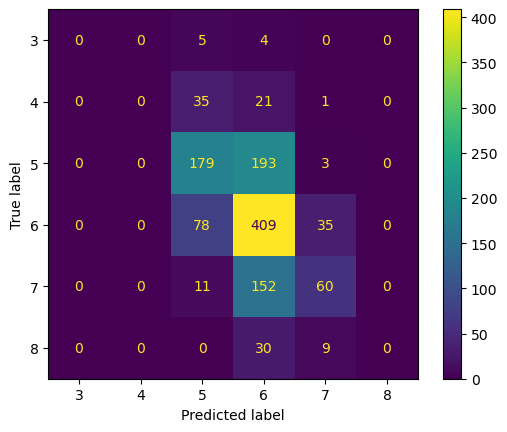

white MinMaxScaler() rfc 

Accuracy of BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [None, 10, 25],
                             'n_estimators': [10, 25, 100], 'n_jobs': [-1],
                             'warm_start': [True, False]}) on white training is: 1.0
Accuracy of BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [None, 10, 25],
                             'n_estimators': [10, 25, 100], 'n_jobs': [-1],
                             'warm_start': [True, False]}) on white test data is: 0.5142857142857142
<class 'pandas.core.series.Series'>
best params: OrderedDict([('bootstrap', False), ('criterion',

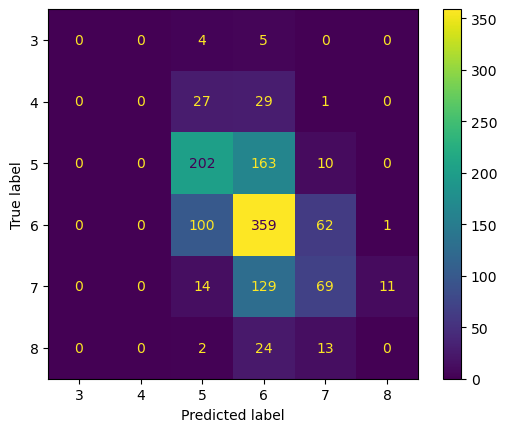

white MinMaxScaler() knn 

Accuracy of BayesSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
              search_spaces={'algorithm': ['ball_tree', 'kd_tree'],
                             'n_jobs': [-1], 'n_neighbors': [5, 10, 25, 50],
                             'weights': ['uniform', 'distance']}) on white training is: 1.0
Accuracy of BayesSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
              search_spaces={'algorithm': ['ball_tree', 'kd_tree'],
                             'n_jobs': [-1], 'n_neighbors': [5, 10, 25, 50],
                             'weights': ['uniform', 'distance']}) on white test data is: 0.47183673469387755
<class 'pandas.core.series.Series'>
best params: OrderedDict([('algorithm', 'ball_tree'), ('n_jobs', -1), ('n_neighbors', 25), ('weights', 'distance')])
this sucks. No idea name 'wi' is not defined


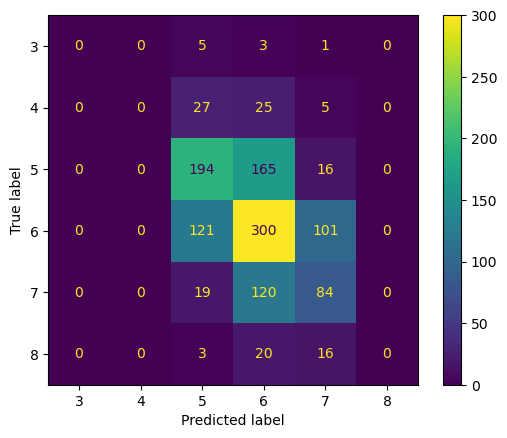

white MinMaxScaler() sgd 

Accuracy of BayesSearchCV(cv=3, estimator=SGDClassifier(), n_jobs=-1,
              search_spaces=[{'early_stopping': [True],
                              'epsilon': [0.05, 0.1, 0.5, 1, 10],
                              'fit_intercept': [True],
                              'loss': ['squared_hinge'], 'max_iter': [2000],
                              'n_jobs': [-1],
                              'penalty': ['l1', 'l2', 'elasticnet'],
                              'tol': [0.001, 0.0001, 1e-05],
                              'warm_start': [True, False]},
                             {'early_stopping': [True],
                              'epsilon': [0.05, 0.1, 0.5, 1, 10],
                              '...
                              'early_stopping': [True], 'fit_intercept': [True],
                              'loss': ['log_loss'], 'max_iter': [2000],
                              'n_jobs': [-1],
                              'penalty': ['l1', 'l2', 'el

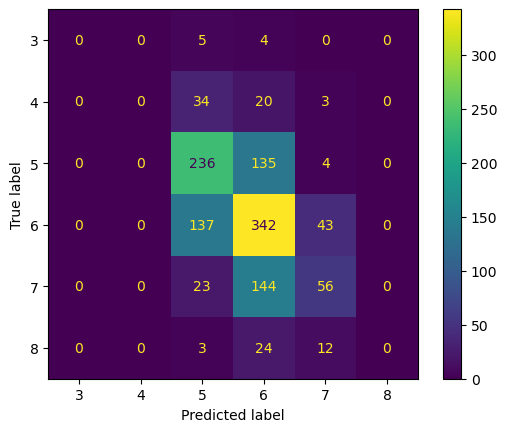

white MinMaxScaler() mlpc 

Accuracy of BayesSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
              search_spaces=[{'activation': ['identity', 'logistic', 'tanh',
                                             'relu'],
                              'alpha': [0.001, 0.0001, 1e-05],
                              'early_stopping': [True], 'max_iter': [1000],
                              'solver': ['adam'], 'tol': [0.001, 0.0001, 1e-05],
                              'warm_start': [True, False]},
                             {'activation': ['identity', 'logistic', 'relu'],
                              'alpha': [0.001, 0.0001, 1e-05],
                              'early_stopping': [True],
                              'learning_rate': ['constant', 'invscaling',
                                                'adaptive'],
                              'max_iter': [1000], 'momentum': [0.9, 0.95, 0.99],
                              'solver': ['sgd'], 'tol': [0.001, 0.0001, 1e-05]

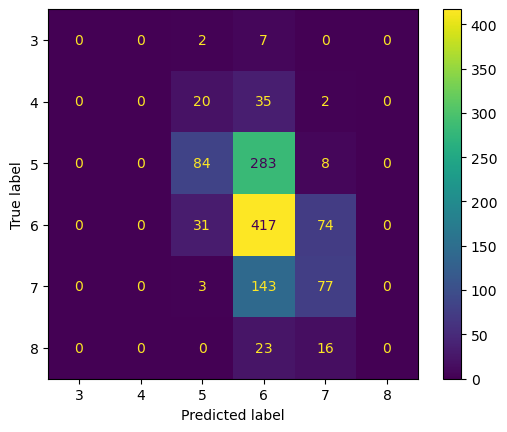

white RobustScaler() rfc 

Accuracy of BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [None, 10, 25],
                             'n_estimators': [10, 25, 100], 'n_jobs': [-1],
                             'warm_start': [True, False]}) on white training is: 1.0
Accuracy of BayesSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [None, 10, 25],
                             'n_estimators': [10, 25, 100], 'n_jobs': [-1],
                             'warm_start': [True, False]}) on white test data is: 0.6448979591836734
<class 'pandas.core.series.Series'>
best params: OrderedDict([('bootstrap', True), ('criterion', 

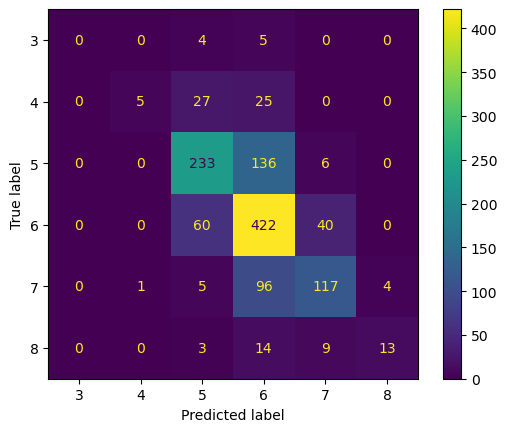

white RobustScaler() knn 

Accuracy of BayesSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
              search_spaces={'algorithm': ['ball_tree', 'kd_tree'],
                             'n_jobs': [-1], 'n_neighbors': [5, 10, 25, 50],
                             'weights': ['uniform', 'distance']}) on white training is: 1.0
Accuracy of BayesSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
              search_spaces={'algorithm': ['ball_tree', 'kd_tree'],
                             'n_jobs': [-1], 'n_neighbors': [5, 10, 25, 50],
                             'weights': ['uniform', 'distance']}) on white test data is: 0.5942857142857143
<class 'pandas.core.series.Series'>
best params: OrderedDict([('algorithm', 'ball_tree'), ('n_jobs', -1), ('n_neighbors', 25), ('weights', 'distance')])
this sucks. No idea name 'wi' is not defined


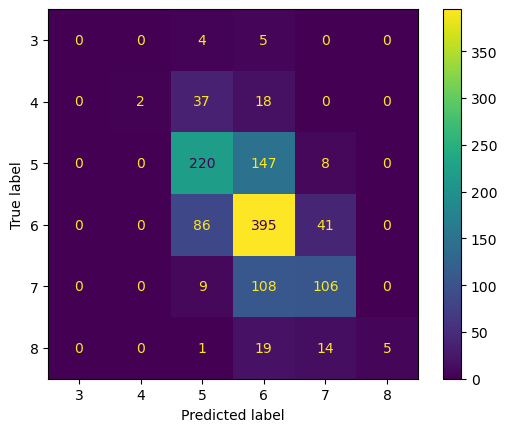

white RobustScaler() sgd 

Accuracy of BayesSearchCV(cv=3, estimator=SGDClassifier(), n_jobs=-1,
              search_spaces=[{'early_stopping': [True],
                              'epsilon': [0.05, 0.1, 0.5, 1, 10],
                              'fit_intercept': [True],
                              'loss': ['squared_hinge'], 'max_iter': [2000],
                              'n_jobs': [-1],
                              'penalty': ['l1', 'l2', 'elasticnet'],
                              'tol': [0.001, 0.0001, 1e-05],
                              'warm_start': [True, False]},
                             {'early_stopping': [True],
                              'epsilon': [0.05, 0.1, 0.5, 1, 10],
                              '...
                              'early_stopping': [True], 'fit_intercept': [True],
                              'loss': ['log_loss'], 'max_iter': [2000],
                              'n_jobs': [-1],
                              'penalty': ['l1', 'l2', 'el

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (6).

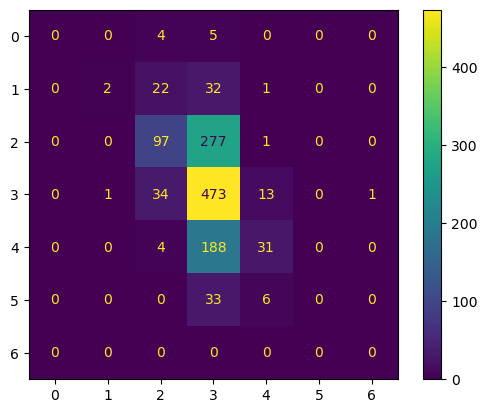

In [30]:
runeval(scales)

In [29]:
performance_scores.sort_values('Test_Score').tail(40)




,Classifier,Wine_Type,Scaler,Training_Score,Test_Score,HP Optimizer Technique
2,sgd,red,StandardScaler(),0.558799,0.5775,bayes
3,mlpc,red,StandardScaler(),0.543786,0.5925,bayes
1,knn,red,StandardScaler(),1.000000,0.6325,bayes
5,knn,red,StandardScaler(),1.000000,0.6325,bayes
7,knn,red,StandardScaler(),1.000000,0.6325,bayes
6,rfc,red,StandardScaler(),0.982485,0.6450,bayes
4,rfc,red,StandardScaler(),1.000000,0.6600,bayes
0,rfc,red,StandardScaler(),1.000000,0.6625,bayes


In [1]:
display(best_params_rfc)
display(best_params_knn)
display(best_params_sgd)
display(best_params_mlpc)

NameError: name 'best_params_rfc' is not defined